In [1]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
# Load the saved models
encoder = tf.keras.models.load_model('encoderCOCO')
decoder = tf.keras.models.load_model('decoderCOCO')


In [4]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

In [5]:


image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [6]:
import pickle

# Load the tokenizer
tokenizer_path = 'tokenizer.pkl'
with open(tokenizer_path, 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)


In [26]:
def evaluate(image):
   attention_plot = np.zeros((44, 49))

   hidden = tf.zeros((1, 512))
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(44):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [27]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

In [28]:
# Compile the encoder and decoder models
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

encoder.compile(optimizer=optimizer)
decoder.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


Real Caption:
Prediction Caption: man riding wave on wave


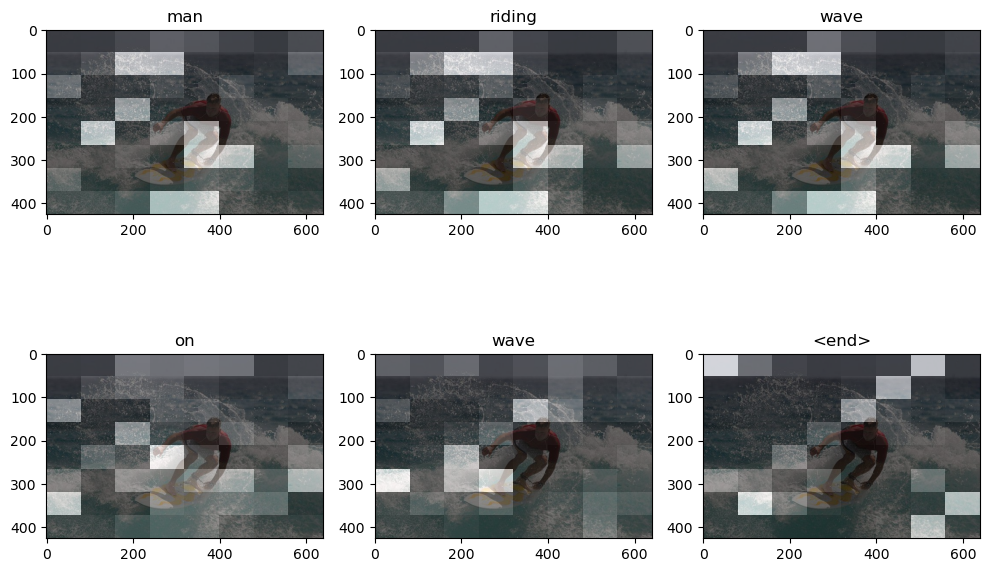

time took to Predict: 1 sec


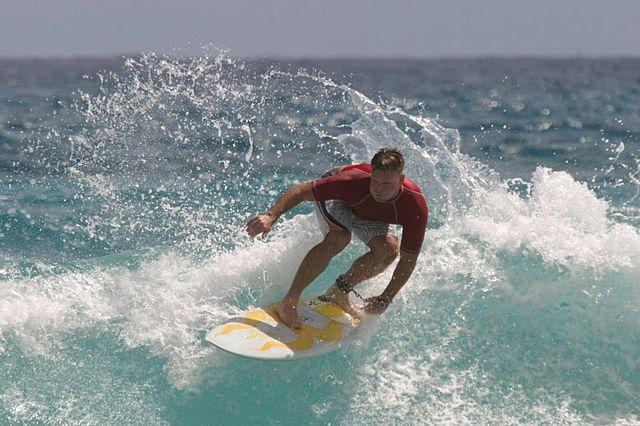

In [34]:
image = 'tmp.jpg'
start = time.time()

result, attention_plot = evaluate(image)


#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]


candidate = result_final

print ('Real Caption:')
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(image)